In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans

file_path = 'cleaning_notebook/AB_cleaned_formatted.xlsx'
sheet_name = 'Sheet1'

df = pd.read_excel(file_path, sheet_name=sheet_name)

In [9]:
def standarizeMethod(df):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    data_scaled_df = pd.DataFrame(data_scaled, columns=df.columns)
    
    return data_scaled_df

def PCAImplementation(df, n, columns):
    # Get n components
    pca = PCA(n_components = n)  
    pca_result = pca.fit_transform(df)

    pca_df = pd.DataFrame(data=pca_result, columns=columns)
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    
    return pca_df

revenue_columns  = [
    "avg_monthly_revenue",
    "avg_monthly_volume", 
    "avg_monthly_promo_revenue", 
    "avg_monthly_transactions", 
    "avg_basket_spend"
]
df = df.replace("Empty", 0)
df_cluster=df
revenue_PCA_df = PCAImplementation(df[revenue_columns], 1, ["revenue_PCA"])
df['revenue_PCA'] = revenue_PCA_df['revenue_PCA']

Explained Variance Ratio: [0.84439266]


In [10]:
# Define the list of columns you want to cluster
#columns_to_cluster = ['avg_monthly_revenue', '# of check-outs', 'SQM Ranges', 'WI',  'Floors',	'Parking (binary)',	'Location']
columns_to_cluster = ['retail_store_id',  'revenue_PCA']


# Extract only these columns into a new DataFrame
data_for_clustering = df[columns_to_cluster]
data_for_clustering = data_for_clustering.replace("Empty", 0)


# Calculate variance for each category
variances = data_for_clustering.var()

# Sort by variance (descending) to identify high-variance features
sorted_variances = variances.sort_values(ascending=False)

print(sorted_variances)

cv = data_for_clustering.std() / data_for_clustering.mean()
cv_sorted = cv.sort_values(ascending=False)

print(cv_sorted)

revenue_PCA        4.235240
retail_store_id    1.003145
dtype: float64
retail_store_id    inf
revenue_PCA        inf
dtype: float64


In [11]:
# Explicitly infer the object types (optional if types need adjustment)
data_for_clustering = data_for_clustering.infer_objects()

# Alternatively, ensure all numeric columns are properly typed
data_for_clustering = data_for_clustering.astype(float)  # Or another type, depending on the context

# Step 1: Standardize the data (important for k-means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

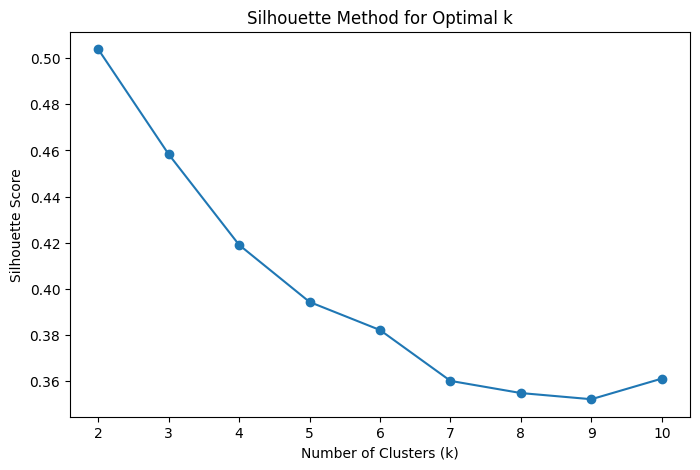

In [12]:
from sklearn.metrics import silhouette_score

# Range of cluster values to test
k_values = range(2, 11)  # Silhouette score requires at least 2 clusters
silhouette_scores = []

# Calculate silhouette score for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [23]:

# Step 3: Fit K-means with optimal number of clusters
optimal_k = 3  # Replace this with your chosen value from the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_scaled)

destandarized_data = scaler.inverse_transform(data_scaled)

# If you want to convert it back into a DataFrame
df_destandarized['retail_store_id',  'revenue_PCA'] = pd.DataFrame(destandarized_data, columns=df.columns)

df_destandarized.to_csv('cluster_results.csv', index=False)

df[columns_to_cluster] = df[columns_to_cluster].apply(pd.to_numeric, errors='coerce')
pd.options.display.float_format = '{:,.2f}'.format

#df_filtered = df[df['Cluster'] != 4]

# Step 4: Analyze the results
cluster_stats = df.groupby('Cluster')[columns_to_cluster].mean()

# Add the size of each cluster to the results
cluster_size = df['Cluster'].value_counts()

# Print the mean values and cluster sizes
print(cluster_stats)
print("\nCluster Sizes:")
print(cluster_size)

ValueError: Shape of passed values is (319, 2), indices imply (319, 49)

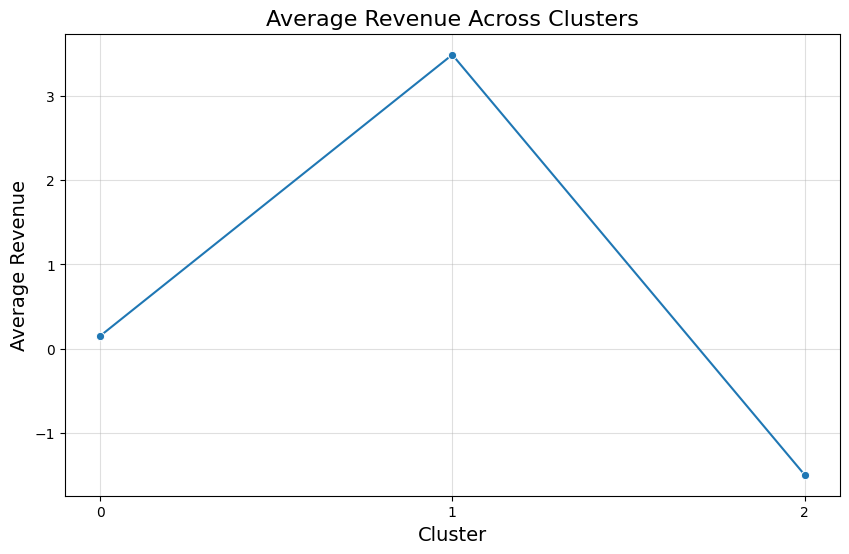

In [15]:
# Resetting index for easy plotting
cluster_stats = cluster_stats.reset_index()

# Line plot for Revenue
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_stats, x='Cluster', y='revenue_PCA', marker='o')
plt.title('Average Revenue Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Revenue', fontsize=14)
plt.xticks(cluster_stats['Cluster'])
plt.grid(alpha=0.4)
plt.show()
